<Figure size 432x288 with 0 Axes>

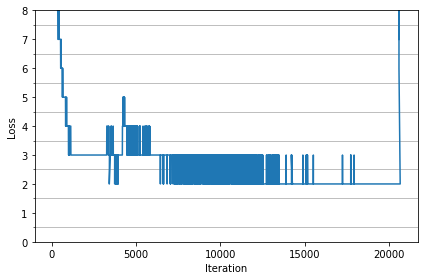

In [1]:
import matplotlib
# %matplotlib notebook
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import cv2,json,os,glob,tqdm
file_name='plot/chart2'
!rm {file_name}
!touch {file_name}
!gen_plot_loss.sh 'logs/vehicle_20200629.out' {file_name}
!gen_plot_loss.sh 'logs/vehicle_20200630.out' {file_name}
!gen_plot_loss.sh 'logs/vehicle_20200701.out' {file_name}

#  46, 252.618362, 294.608795, 0.000000 rate, 10.696133 seconds, 2944 images, 342.430691 hours left
#  47, 249.831772, 290.131104, 0.000000 rate, 10.663156 seconds, 3008 images, 340.490596 hours left
#  48, 249.905640, 286.108551, 0.000000 rate, 10.666563 seconds, 3072 images, 338.565297 hours left
#  49, 251.424896, 282.640198, 0.000000 rate, 10.693722 seconds, 3136 images, 336.659694 hours left
#  50, 251.682617, 279.544434, 0.000000 rate, 10.680716 seconds, 3200 images, 334.776886 hours left
iterations, losses=[],[]
with open(file_name,'r') as fid:
    for line in fid.readlines():
        line=line.strip()
        try:
            losses.append(int(float(line.split(',')[2])))
            iterations.append(int(line.split(',')[0]))
        except:
            continue
plt.clf()
fig, ax = plt.subplots()
# set area we focus on
ax.set_ylim(0, 8)

major_locator = MultipleLocator()
minor_locator = MultipleLocator(0.5)
ax.yaxis.set_major_locator(major_locator)
ax.yaxis.set_minor_locator(minor_locator)
ax.yaxis.grid(True, which='minor')
ax.plot(iterations, losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()


In [2]:
!nvidia-smi

Wed Jul  1 14:02:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   63C    P0   118W / 250W |  25466MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:88:00.0 Off |                    0 |
| N/A   65C    P0   197W / 250W |  25159MiB / 32510MiB |     14%      Default |
+-------------------------------+----------------------+----------------------+
        

In [88]:
import sqlite3
import base64
import json
import os
import traceback
import logging
import glob
from fvcore.common.timer import Timer
from detectron2.utils.visualizer import Visualizer
# import tempfile
# import uuid
# from io import BytesIO
#
import cv2
import matplotlib.pyplot as plt
from detectron2.structures import Instances
import numpy as np
_SMALL_OBJECT_AREA_THRESH = 1000
thing_classes = ['car','truck','bus','motorcycle','bicycle','trains']
HAS_GPU = True
import darknet 
darknet.hasGPU = HAS_GPU
if HAS_GPU:
    from darknet import set_gpu
uselib=darknet    

In [37]:
# try:
#     del yoyo
# except:
#     pass
# yoyo = YOLO_single_img(
#                        configPath="cfg/vehicle.cfg", 
# #                        configPath="cfg/yolov4.cfg", 
#                        weightPath="backup/vehicle_last.weights",
# #                        weightPath="cfg/yolov4-sam-mish-512.weights",
# #                        weightPath="cfg/yolov4.weights",
#                        metaPath="cfg/vehicle.data",gpu_id=1)

In [90]:
allimagesfiles=[]
with open('cfg/train.txt','r') as fid:
    allimagesfiles.extend([x for x in list(map(str.strip,fid.readlines())) if 'car' in x])
xx=iter([allimagesfiles[x] for x  in np.random.choice(len(allimagesfiles),100,replace=False)])    

In [91]:
netMain = None
metaMain = None
altNames = None
configPath = "cfg/vehicle.cfg"
weightPath = "backup/vehicle_last.weights"
metaPath = "cfg/vehicle.data"
set_gpu(1)
if not os.path.exists(configPath):
    raise ValueError("Invalid config path `" +
                     os.path.abspath(configPath) + "`")
if not os.path.exists(weightPath):
    raise ValueError("Invalid weight path `" +
                     os.path.abspath(weightPath) + "`")
if not os.path.exists(metaPath):
    raise ValueError("Invalid data file path `" +
                     os.path.abspath(metaPath) + "`")
if netMain is None:
    netMain = darknet.load_net_custom(configPath.encode(
        "ascii"), weightPath.encode("ascii"), 0, 1)  # batch size = 1
if metaMain is None:
    metaMain = darknet.load_meta(metaPath.encode("ascii"))
if altNames is None:
    try:
        with open(metaPath) as metaFH:
            metaContents = metaFH.read()
            import re
            match = re.search("names *= *(.*)$", metaContents,
                              re.IGNORECASE | re.MULTILINE)
            if match:
                result = match.group(1)
            else:
                result = None
            try:
                if os.path.exists(result):
                    with open(result) as namesFH:
                        namesList = namesFH.read().strip().split("\n")
                        altNames = [x.strip() for x in namesList]
            except TypeError:
                pass
    except Exception:
        pass
darknet_image = darknet.make_image(darknet.network_width(netMain),
                                           darknet.network_height(netMain), 3)

In [92]:
def convertBack(detection):
    x, y, w, h = detection
    x, y, w, h = float(x), float(y), float(w), float(h)
    xmin = int(round(x - (w / 2)))
    xmax = int(round(x + (w / 2)))
    ymin = int(round(y - (h / 2)))
    ymax = int(round(y + (h / 2)))
    return xmin, ymin, xmax, ymax

In [9]:
darknet.load_net_custom("cfg/vehicle.cfg".encode("ascii"), "backup/vehicle_last.weights".encode("ascii"), 0, 1)

896815792

In [112]:
def kill_duplicate_by_score(prediction, xou_thres=.7):
    from itertools import combinations
    def bb_intersection_over_union(boxA, boxB):
        boxA = (boxA[0], boxA[1], boxA[0] + boxA[2], boxA[3] + boxA[1])
        boxB = (boxB[0], boxB[1], boxB[0] + boxB[2], boxB[3] + boxB[1])
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        # compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
        # return the intersection over union value
        return iou

    prediction[:] = [x for x in prediction if float(x[1]) > .5]

    boxcombins = combinations(prediction, 2)
    for boxcomb in boxcombins:
        try:
            xou = bb_intersection_over_union(boxcomb[0][2], boxcomb[1][2])
            if xou > float(xou_thres):
                prediction.remove(boxcomb[1] if boxcomb[0][1] > boxcomb[1][1] else boxcomb[0])
        except:
            continue

    return prediction

('car', 0.5513402223587036, (332.39215087890625, 359.1761779785156, 566.8775634765625, 503.3076477050781))
('truck', 0.30799180269241333, (332.36285400390625, 344.0808410644531, 561.5469360351562, 496.47698974609375))
************** one shot detect time is 0.02 and 50 fps.**************


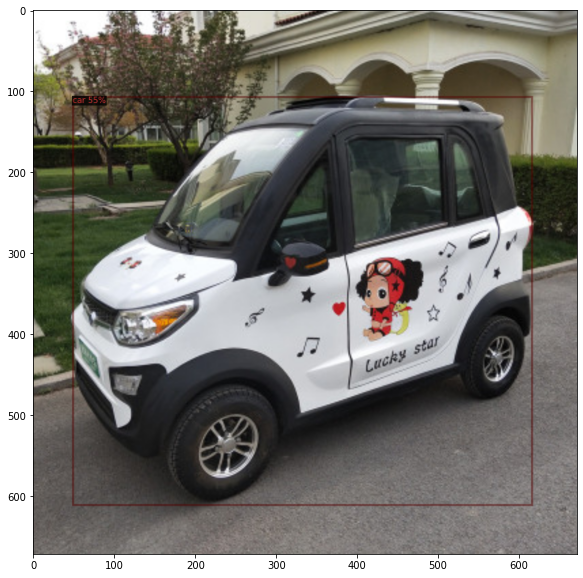

In [115]:
# frame_read=cv2.imread(next(xx))
frame_rgb = cv2.cvtColor(frame_read, cv2.COLOR_BGR2RGB)
frame_resized = cv2.resize(frame_rgb,
                           (darknet.network_width(netMain),
                            darknet.network_height(netMain)),
                           interpolation=cv2.INTER_LINEAR)

darknet.copy_image_from_bytes(darknet_image, frame_resized.tobytes())
tt=Timer()
dd = darknet.detect_image(netMain, metaMain, darknet_image, thresh=0.25)
# img=cv2.imread(next(xx))
# next(xx);next(xx);next(xx);next(xx);next(xx)
# img=cv2.imread('download.jpg')
# cap=cv2.VideoCapture("mq17cc36c1000440-20200611100500.mp4")
# _,img=cap.read()
# dd,kitchen_img_resized=darknet.detect_image(img)
for i in dd:print(i)
dd=kill_duplicate_by_score(dd,xou_thres=1)
# frame_resized = cv2.resize(img,(608, 608),interpolation=cv2.INTER_LINEAR)
# image = cvDrawBoxes(dd, frame_resized)
# image = cv2.cvtColor(cv2.imread('mq291bb92e000113-155449.jpg'), cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(15,15))
# plt.imshow(image[:,:,::-1])

tt.pause()
coco_thing_classes=['person','bicycle','car','motorbike','aeroplane','bus','train','truck','boat','traffic light','fire hydrant','stop sign','parking meter','bench','bird','cat','dog','horse','sheep','cow','elephant','bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket','bottle','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','sofa','pottedplant','bed','diningtable','toilet','tvmonitor','laptop','mouse','remote','keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','book','clock','vase','scissors','teddy bear','hair drier','toothbrush']
vlz = Visualizer(frame_resized, {"thing_classes": thing_classes}, instance_mode=1)
        # "pred_boxes":,"scores","pred_classes"
instance = Instances((darknet.network_width(netMain),
                            darknet.network_height(netMain)),
                     **{"pred_boxes": np.array(list(map(convertBack, [x[2] for x in dd]))),
                        "scores": np.array([x[1] for x in dd]),
                        "pred_classes": np.array([thing_classes.index(x[0]) for x in dd])})
# vout = vlz.draw_instance_predictions(predictions=(instance[5]))
vout = vlz.draw_instance_predictions(predictions=instance)
kitchen_img_resized = vout.get_image()
plt.figure(figsize=(10,10))
plt.imshow(kitchen_img_resized)

print(f'************** one shot detect time is {tt.seconds():.2f} and {int(float(1/tt.seconds()))} fps.**************')

In [1]:
from ctypes import *
import math
import random
import os
import cv2
import numpy as np
import time
import darknet
from darknet import set_gpu



netMain = None
metaMain = None
altNames = None


configPath = "./cfg/yolov4.cfg"
weightPath = "./cfg/yolov4.weights"
metaPath = "./cfg/coco.data"
if not os.path.exists(configPath):
    raise ValueError("Invalid config path `" +
                     os.path.abspath(configPath)+"`")
if not os.path.exists(weightPath):
    raise ValueError("Invalid weight path `" +
                     os.path.abspath(weightPath)+"`")
if not os.path.exists(metaPath):
    raise ValueError("Invalid data file path `" +
                     os.path.abspath(metaPath)+"`")
set_gpu(5)    
if netMain is None:
    netMain = darknet.load_net_custom(configPath.encode(
        "ascii"), weightPath.encode("ascii"), 0, 1)  # batch size = 1
if metaMain is None:
    metaMain = darknet.load_meta(metaPath.encode("ascii"))
if altNames is None:
    try:
        with open(metaPath) as metaFH:
            metaContents = metaFH.read()
            import re
            match = re.search("names *= *(.*)$", metaContents,
                              re.IGNORECASE | re.MULTILINE)
            if match:
                result = match.group(1)
            else:
                result = None
            try:
                if os.path.exists(result):
                    with open(result) as namesFH:
                        namesList = namesFH.read().strip().split("\n")
                        altNames = [x.strip() for x in namesList]
            except TypeError:
                pass
    except Exception:
        pass




In [21]:
# import the necessary packages
import numpy as np
import urllib.request
import cv2
# METHOD #1: OpenCV, NumPy, and urllib
def url_to_image(urlx):
    # download the image, convert it to a NumPy array, and then read
    with urllib.request.urlopen(urlx) as url:
        resp = url
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        # return the image
        return image

In [12]:
# import ssl

# ssl._create_default_https_context = ssl._create_unverified_context
# # Create an image we reuse for each detect
# darknet_image = darknet.make_image(darknet.network_width(netMain),
#                                 darknet.network_height(netMain),3)
# #     while True:
# prev_time = time.time()
# #     ret, frame_read = cap.read()
# #     frame_read=cv2.imread('')
# # img=cv2.imread(next(xx))
# xxx=\
# 'https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1593409854951&di=1412a4026ce11569c9f1e02d783a4753&imgtype=0&src=http%3A%2F%2Fimg.jdzj.com%2FUserDocument%2F2013c%2Fwanhuali158%2FPicture%2F201422144014.jpg'
# img=url_to_image(xxx)
# frame_read=img
# frame_rgb = cv2.cvtColor(frame_read, cv2.COLOR_BGR2RGB)
# frame_resized = cv2.resize(frame_rgb,
#                            (darknet.network_width(netMain),
#                             darknet.network_height(netMain)),
#                            interpolation=cv2.INTER_LINEAR)

# darknet.copy_image_from_bytes(darknet_image,frame_resized.tobytes())

# detections = darknet.detect_image(netMain, metaMain, darknet_image, thresh=0.25)
# # print('\n',detections)
# image = cvDrawBoxes(detections, frame_resized)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# print(1/(time.time()-prev_time),'\n','\n',detections)
# plt.figure(figsize=(15,15))
# plt.imshow(image[:,:,::-1])
# #         cv2.imshow('Demo', image)
# #         cv2.waitKey(3)
# #     cap.release()
# #     out.release()


[{'type': 'truck', 'location': {'width': 712, 'top': 72, 'left': 4, 'height': 727}, 'probability': 0.7409517168998718}]


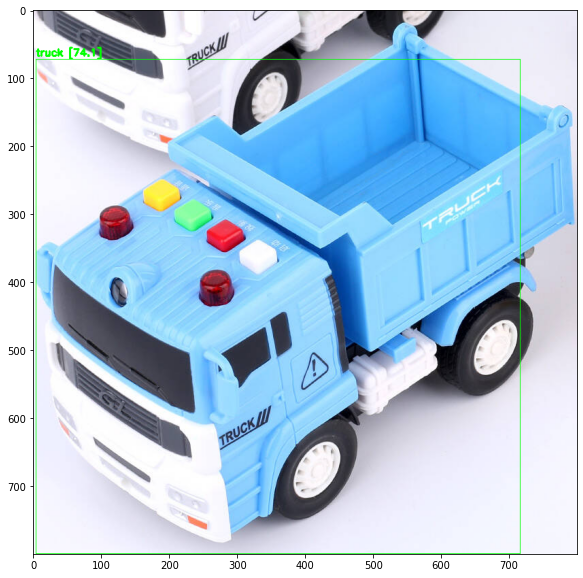

In [36]:
# !cat /home/yuanpu/vehicle/data/baiduimg/car/labels/200-Baidu_1444.txt
baiduimgid='Baidu_0050'

ann_template='/home/yuanpu/vehicle/data/baiduimg/car/labels/200-{}.txt'
img_template='/home/yuanpu/vehicle/data/baiduimg/car/{}.jpeg'
with open(ann_template.format(baiduimgid),'r') as fid:
    ann=json.loads(''.join(list(map(str.strip,fid.readlines()))))
v_info=ann['vehicle_info']
print(v_info)
detections=[]
for v in v_info:
    x,y,w,h=v['location']['left'],v['location']['top'],v['location']['width'],v['location']['height']
    d0,d1,d2,d3,d4,d5=v['type'],v['probability'],x,y,w,h
    detections.append((d0.encode('utf-8'),d1,(d2,d3,d4,d5)))
plt.figure(figsize=(10,10))
img=cvDrawBoxes(detections, cv2.imread(img_template.format(baiduimgid)))
plt.imshow(img[:,:,::-1])

# cvDrawBoxes(detections, img)
# ('mask-cap', 0.9536643624305725, (153.5623321533203, 219.74835205078125, 22.459575653076172, 38.7485466003418))
# ('mask-cap', 0.9107463359832764, (258.45843505859375, 171.0248565673828, 17.897512435913086, 30.07501792907715))
# ('mask-cap', 0.9073424339294434, (139.93243408203125, 186.2634735107422, 16.61669158935547, 27.81591796875))
# ('mask-cap', 0.6785228252410889, (107.55332946777344, 201.98892211914062, 16.53424644470215, 33.16963195800781))

In [11]:

def convertBack(x, y, w, h):
    xmin = int(round(x - (w / 2)))
    xmax = int(round(x + (w / 2)))
    ymin = int(round(y - (h / 2)))
    ymax = int(round(y + (h / 2)))
    return xmin, ymin, xmax, ymax


def cvDrawBoxes(detections, img):
    for detection in detections:
        x, y, w, h = detection[2][0], \
                     detection[2][1], \
                     detection[2][2], \
                     detection[2][3]
        xmin, ymin, xmax, ymax = float(x), float(y), float(w)+float(x), float(h)+float(y)
#         print(x, y, w, h,'\n',xmin, ymin, xmax, ymax)
        pt1 = (int(xmin), int(ymin))
        pt2 = (int(xmax), int(ymax))
        cv2.rectangle(img, pt1, pt2, (0, 255, 0), 1)
        cv2.putText(img,
                    detection[0].decode() +
                    " [" + str(round(detection[1] * 100, 2)) + "]",
                    (pt1[0], pt1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    [0, 255, 0], 2)
    return img

In [14]:
def convert_xminymin_xcenterycenter(h, w, xmin, ymin, xmax, ymax):
    # < x_center > < y_center > < width > < height > - float values relative to width and height of image, it can  be  equal from (0.0 to 1.0]
    dw = 1. / (float(w))
    dh = 1. / (float(h))
    x = (xmin + xmax) / 2.0

    y = (ymin + ymax) / 2.0
    w = xmax - xmin
    h = ymax - ymin
    x = round(x * dw, 6)
    w = round(w * dw, 6)
    y = round(y * dh, 6)
    h = round(h * dh, 6)
    #     return x, y, w, h
    return f'{x} {y} {w} {h}'

In [29]:
imagefile_ext='jpg'
data_dir='/home/yuanpu/vehicle/data/{}'
baidu_ann_template=f'{data_dir}'+'/labels/200-{}.txt'
yolo_ann_template = f'{data_dir}'+'/{}.txt'
image_filename_template=f'{data_dir}'+'/{}.'+f'{imagefile_ext}'

thing_classes = ['car','truck','bus','motorbike','bicycle','trains']
class_names=['cars_train']
for c in class_names:
    f_ids=[os.path.basename(x).split('.')[0] for x in glob.glob(data_dir.format(c)+f'/*.{imagefile_ext}')]
    for f_id in f_ids:
        ann_file_name=baidu_ann_template.format(c,f_id)
#         print(ann_file_name)
#         print(yolo_ann_template.format(c,f_id))
        with open(ann_file_name,'r') as fid:
            ann=json.loads(''.join(list(map(str.strip,fid.readlines()))))
        try:
            v_info=ann['vehicle_info']
        except:
            continue
        detections=[]
        iiiii=cv2.imread(image_filename_template.format(c,f_id))
#         print(image_filename_template.format(c,f_id))
        for v in v_info:
            x,y,w,h=v['location']['left'],v['location']['top'],v['location']['width'],v['location']['height']
            d0,d1,d2,d3,d4,d5=v['type'],v['probability'],x,y,w,h
            if d0 not in thing_classes:
#                 print(f'd0{d0} not in {thing_classes}')
                continue
            
            
            xh,xw=iiiii.shape[0],iiiii.shape[1]
            detections.append(f"{thing_classes.index(d0)} {convert_xminymin_xcenterycenter(xh,xw,d2,d3,d4+d2,d5+d3)}")
        with open(yolo_ann_template.format(c,f_id),'w') as fid:
            for xd in detections:
#                 print(xd,'=====')
                fid.write(xd+'\n')
#         break
#     break
#3 0.431562 0.476744 0.615137 0.061311
#3 0.583878 0.939583 0.832244 0.120833

In [73]:
# # /home/yuanpu/vehicle/data/baiduimg/car> Baidu_1490.txt

# def cvDrawBoxes(detections, img):
#     print(img.shape)
#     for detection in detections:
#         x, y, w, h = detection[2][0], \
#                      detection[2][1], \
#                      detection[2][2], \
#                      detection[2][3]
#         xmin, ymin, xmax, ymax = convertBack(
#             float(x), float(y), float(w), float(h))
#         pt1 = (xmin, ymin)
#         pt2 = (xmax, ymax)
#         cv2.rectangle(img, pt1, pt2, (0, 255, 0), 1)
#         cv2.putText(img,
#                     detection[0].decode() +
#                     " [" + str(round(detection[1] * 100, 2)) + "]",
#                     (pt1[0], pt1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                     [0, 255, 0], 2)
#     return img
# img=cv2.imread('/home/yuanpu/vehicle/data/baiduimg/car/Baidu_1490.jpeg')
# dd=[(b'2',0.3,(0.380645, 0.529032 ,0.23871  ,0.212903)),
# (b'2',0.3,(0.640323, 0.517742 ,0.241935 ,0.190323)),
# (b'2',0.3,(0.296774, 0.374194 ,0.122581 ,0.103226)),
# (b'2',0.3,(0.427419, 0.379032 ,0.119355 ,0.093548)),
# (b'2',0.3,(0.675806, 0.380645 ,0.125806 ,0.083871)),
# (b'2',0.3,(0.558065, 0.398387 ,0.135484 ,0.132258)),
# (b'5',0.3,(0.174194, 0.504839 ,0.296774 ,0.216129))]
# img=cvDrawBoxes(dd,img)
# plt.figure(figsize=(10,10))
# plt.imshow(img)

